# Deep Learning for text

## Natural language processing: Bird's eye view

In CS, we refer to human language as 'natural' languages, to distinguish them form languages designed for machines. Every machine language was designed: its starting point was a human engineer writing down a set of formal rules to describe what statements you could make in that language and what they meant.Rules came first, and people only started using the language once the rule set was complete. With human language, it's the reverse: usage comes first, rules arise later. Natural language was shaped by an evolution process, much like biological organisms - that's what makes it "natural". Its "rules", like the grammar of English, were formalized after the fact and are often ignored or broken by its users. As a result, while machine-readable language is highly structured and rigorous, using precise syntactic rules to weave together exactly defined concepts from a fixed vocabulary, natural language is messy-ambiguous, chaotic, sprawling, and constantly in flux.\
Modern NLP is about using machine learning and large datasets to give computers the ability not to understand language, which is a more lofty goal, but to ingest a piece of language as input and return something useful, like predicting the following:
* Text classification
* Content filtering
* Sentiment Analysis
* Language modeling
* Translation
* Summarization
* etc..

## Preparing text data
Deep learning models, being differentiable functions, can only process numeric tensors: they can't take raw text as input. Vectorizing text is the process of transforming text into numeric tensors. Text vectorization processes come in many shapes and forms, but they all follow the same template:
* First, you standardize the text to make it easier to process, such as by converting it to lowercase or removing punctuation.
* You split the text into units (called tokens), such as characters, word, or groups of words. This is called tokenization.
* You convert each such token into a numerical vector. This will usually involve firts indexing all tokens present in the data.\
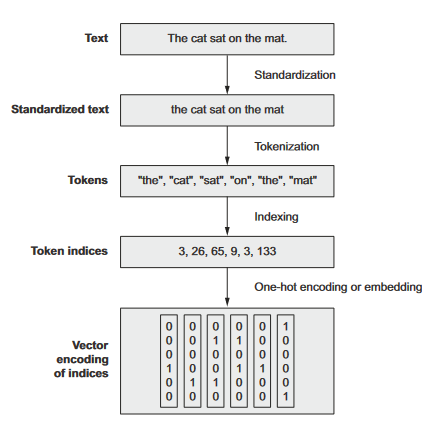

### Test standardization
Consider two senteces:
* "sunset came. i was staring at the Mexico sky. Isnt nature splendid??"
* "Sunset came; I stared at the México sky. Isn't nature splendid?"
They are very similar, almost identical. Yet, if you were to convert them to byte strings, they would end up with very different representations, because "i" and "I" are two different characters, and so on. A machine learning model does not know a priori that "i" and "I" are the same letter, and so on.
Text standardization is a basic form of feature engineering that aims to erase encoding differences that you don't want your model to have to deal with. It is not exclusive to machine learning either, you would have to do the same thing if you were building a search engine.\
One of the simplest and most widespread standardization schemes is "convert to lowercase and remove punctuation characters". Another comon transformation is converting special characters to a standard form.\
Lastly, a much more advanced standardization pattern that is more rarely used in a machine learning context is stemming. converting variations of a term into a single shared represetnation.\
With these standardization techniques, your model will require less training data and will generalize better. Of course, standardization may also erase some amount of information, so always keep the context in mind.

### Text splitting (Tokenization)

Once your text is standardized, you need to break it up into units to be vectorized, a step called tokenization. You could do this in three different ways:
* Word-level: tokens are space-separated (or punctuation separated) substrings. A variant of this is to further split words into subwords when applicable.
* N-gram: tokens are groups of N consecutive words.
* Character-level: each character is its own token. Rarely used.
In general, you always use word-level or N-gram tokenization. There are two kinds of text-processing models: those that care about word order, called sequence models, and those that treat input words as a set, discarding their original order, called bag-of-words models. If you are bulding a  sequence model, you will use word-level and if you are building a bag-of-words model, you will use N-gram. N-grams are a way to artificially inject a small amount of ocal word order information into the model.

### Vocabulary indexing
Once the text is split into tokens, you need to encode each token into a numerical representation. You could potentially do this in a stateless way, such as by hashing each token into a fixed binary vector, but in practice, the way you'd go about it is to build an index of all terms found in the training data, and assign a unique integer to each entry in vocabulary.

In [ ]:
# vocabulary = {}

# for text in dataset:
#     text = standardize(text)
#     tokens = tokenize(text)
#     for token in tokens:
#         if token not in vocabulary:
#             vocabulary[token]=len(vocabulary)

You can then convert that integer into a vector encodign that can be processed by a neural network like one-hot vector:

In [ ]:
# def one_hot_encode_token(token):
#     vector = np.zeros((len(vocabulary),))
#     token_index = vocabulary[token]
#     vector[token_index]=1
#     return vector

At this step is common to restrict the vocabulary to only the top 20,000 or 30,000 most common words found in the training data. Any text dataset tends to feature an extremely large number of unique terms, most of which only show up once or twice.
Now, there is an important detail here that we should not overlook: when we look up a new token in out vocabulary index, it may not necessarily exist. Your training data may not have contained any instance of a word, so looking for the index may result in KeyError. To handle this, you should use an "out of vocabulary" index (OOV) - a catch-all for any token that wasn't in the index. It is usually index 1: uyou are actually doing token_index = vocabulary.get(token,1). When decoding a sequence of integers back into words, you will replace 1 with something like "[UNK]". “Why use 1 and not 0?” you may ask. That’s because 0 is already taken. There are
two special tokens that you will commonly use: the OOV token (index 1), and the
mask token (index 0). While the OOV token means “here was a word we did not recog-
nize,” the mask token tells us “ignore me, I’m not a word.” You’d use it in particular to
pad sequence data: because data batches need to be contiguous, all sequences in a
batch of sequence data must have the same length, so shorter sequences should be
padded to the length of the longest sequence.

### Using the TextVectorization layer

In [1]:
import string

class Vectorizer:
    def standardize(self, text):
        text = text.lower()
        return "".join(char for char in text if char not in string.punctuation)
    
    def tokenize(self, text):
        text=self.standardize(text)
        return text.split()
    
    def make_vocabulary(self, dataset):
        self.vocabulary = {"":0, "[UNK]":1}
        for text in dataset:
            text = self.standardize(text)
            tokens = self.tokenize(text)
            for token in tokens:
                if token not in self.vocabulary:
                    self.vocabulary[token] = len(self.vocabulary)
        self.inverse_vocabulary = dict((v,k) for k,v in self.vocabulary.items())
    
    def encode(self, text):
        text = self.standardize(text)
        tokens = self.tokenize(text)
        return [self.vocabulary.get(token,1) for token in tokens]
    
    def decode(self,int_sequence):
        return " ".join(self.inverse_vocabulary.get(i,"[UNK]") for i in int_sequence)

vectorizer = Vectorizer()

dataset = ["I write, erase, rewrite", "Erase again, and then", "A poppy blooms."]

vectorizer.make_vocabulary(dataset)

In [2]:
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = vectorizer.encode(test_sentence)
print(encoded_sentence)
decoded_sentence=vectorizer.decode(encoded_sentence)
print(decoded_sentence)

[2, 3, 5, 7, 1, 5, 6]
i write rewrite and [UNK] rewrite again


This wouldn't be very performant. In practice, you will work with the Keras TextVectorization layer, which is fast and efficient and can be dropped directly into a tf.data pipeline or Keras model.

In [4]:
from tensorflow.keras.layers import TextVectorization
text_vectorization = TextVectorization(output_mode='int')

By default the TextVectorization layer will use the setting "convert to lowercase and remove punctuation" for text standardization, and "split on whitespace" for tokenization. You can provide custom functions for standardization and tokenization, which means the layer is flexible enough to handle any use case. Note that such custom fucntions should operate on tf.string tensors.

In [6]:
import re
import string
import tensorflow as tf

def custom_standardization_fn(string_tensor):
    lowercase_string=tf.strings.lower(string_tensor)
    return tf.strings.regex_replace(lowercase_string, f"{re.escape(string.punctuation)}", "")

def custom_split_fn(string_tensor):
    return tf.strings.split(string_tensor)

text_vectorization=TextVectorization(output_mode="int", standardize=custom_standardization_fn,split=custom_split_fn)

dataset = ["I write, erase, rewrite", "Erase again, and then", "A poppy blooms."]

text_vectorization.adapt(dataset)

#Retrieve the computed vocabulary
text_vectorization.get_vocabulary()

['',
 '[UNK]',
 'write,',
 'then',
 'rewrite',
 'poppy',
 'i',
 'erase,',
 'erase',
 'blooms.',
 'and',
 'again,',
 'a']

In [7]:
#Let's try to encode then decode an example sentence

vocabulary = text_vectorization.get_vocabulary()
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = text_vectorization(test_sentence)
print(encoded_sentence)
inverse_vocab=dict(enumerate(vocabulary))
decoded_sentence = " ".join(inverse_vocab[int(i)] for i in encoded_sentence)
print(decoded_sentence)

tf.Tensor([ 6  2  1 10  1  4  1], shape=(7,), dtype=int64)
i write, [UNK] and [UNK] rewrite [UNK]


Importantly, because TextVectorization is mostly a dictionary lookup operation, it
can’t be executed on a GPU (or TPU)—only on a CPU. So if you’re training your model
on a GPU, your TextVectorization layer will run on the CPU before sending its out-
put to the GPU. This has important performance implications.

## Two approaches for representing groups of words: Sets and sequences

